In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read in the file here

In [7]:
spotify = pd.read_csv('Data/SpotifyFeatures0419.csv')

spotify.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


###### sklearn knn test
<br>
This was just something I tried in order to practice new material. I now know that this is a classification model, and not suited for what I was trying to accomplish.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

X = spotify[['acousticness', 'danceability', 'energy', 'speechiness']].head()
y = spotify.popularity.head()

X_new = spotify[['acousticness', 'danceability', 'energy', 'speechiness']].iloc[6:11, :]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [23]:
knn.predict(X_new)

array([0, 0, 0, 0, 0], dtype=int64)

<b>Investigating correlations in the spotify data</b>

In [5]:
spotify.corr()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
acousticness,1.000000,-0.360462,0.033426,-0.710067,0.272685,-0.019987,-0.100545,-0.603366,0.067171,-0.119231,-0.216328,-0.165319,-0.177023,-0.116520
danceability,-0.360462,1.000000,-0.126781,0.286196,-0.305112,0.021123,-0.137377,0.431554,-0.057912,0.248192,0.081791,0.206328,0.461468,0.131086
duration_ms,0.033426,-0.126781,1.000000,-0.019885,0.029124,-0.001880,-0.003661,-0.018595,0.010321,-0.101955,-0.009657,0.021007,-0.141837,-0.000801
energy,-0.710067,0.286196,-0.019885,1.000000,-0.301308,0.039843,0.209448,0.766697,-0.069263,0.105078,0.229930,0.165030,0.314768,0.122506
instrumentalness,0.272685,-0.305112,0.029124,-0.301308,1.000000,-0.025072,-0.058390,-0.508519,-0.002211,-0.217359,-0.086894,-0.084223,-0.246869,-0.216447
key,-0.019987,0.021123,-0.001880,0.039843,-0.025072,1.000000,0.009191,0.028101,-0.176238,0.010354,0.005464,0.008878,0.043348,0.002682
liveness,-0.100545,-0.137377,-0.003661,0.209448,-0.058390,0.009191,1.000000,0.062168,-0.001325,0.106801,-0.009126,-0.018307,-0.007800,-0.031174
loudness,-0.603366,0.431554,-0.018595,0.766697,-0.508519,0.028101,0.062168,1.000000,-0.036081,0.074456,0.223067,0.179679,0.319881,0.244088
mode,0.067171,-0.057912,0.010321,-0.069263,-0.002211,-0.176238,-0.001325,-0.036081,1.000000,-0.053554,-0.000249,-0.036244,0.011082,-0.009070
speechiness,-0.119231,0.248192,-0.101955,0.105078,-0.217359,0.010354,0.106801,0.074456,-0.053554,1.000000,0.054827,0.053707,0.121552,-0.000214


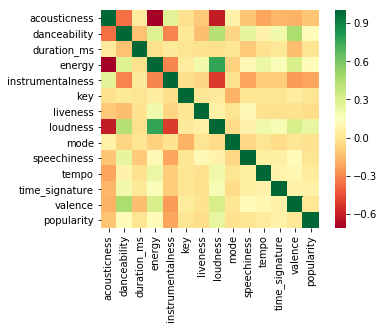

In [6]:
import seaborn as sns

sns.heatmap(spotify.corr(), square=True, cmap='RdYlGn')

Here's a rudimentary attempt at a linear regression model:

In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split

#pick a few independent variables, and set the dependent variable
X = spotify[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness']]
y = spotify.popularity

#fit and predict the model
lm = LinearRegression()
lm.fit(X,y)
lm.predict(X)[:2]

array([29.37066237, 26.99189831])

In [10]:
lm.score(X,y)

0.07074781553598763

The score for this model is pretty poor.

<b>pd.get_dummies</b>

In [18]:
encoded = so.drop('track_name', axis=1)
encoded = encoded[encoded['popularity'] > 10]

encoded = pd.get_dummies(encoded)

In [19]:
encoded.shape

(90468, 24725)

In [22]:
list(encoded.columns)[10:30]

['tempo',
 'time_signature',
 'valence',
 'popularity',
 'artist_name_!!!',
 'artist_name_"Calendar Girls" Original London Cast',
 'artist_name_"Elena Of Avalor" Cast',
 'artist_name_"Puppy Dog Pals" Cast',
 'artist_name_"Weird Al" Yankovic',
 'artist_name_$MGGLR',
 'artist_name_$NOT',
 'artist_name_$US VALENTINO',
 'artist_name_$avage',
 'artist_name_$hirak',
 'artist_name_$kinny Noodle',
 'artist_name_$mooth thoma$',
 'artist_name_$teven Cannon',
 'artist_name_$tranger',
 'artist_name_$tupid Young',
 'artist_name_$ubjectz']

#### Explore the target column: popularity

In [5]:
spotify['popularity'].describe()

count    130663.000000
mean         24.208988
std          19.713191
min           0.000000
25%           7.000000
50%          22.000000
75%          38.000000
max         100.000000
Name: popularity, dtype: float64

In [11]:
#order the data by the target column; drop the track_id and superfluous index column
spotify_ordered = spotify.sort_values('popularity', ascending=False).reset_index()
so = spotify_ordered.drop(['index', 'track_id'], axis=1)

#start index at 1 to accurately see where popularities rank
so.index = so.index + 1
so.head(9)

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1,Daddy Yankee,Con Calma,0.1100,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100
2,Post Malone,Wow.,0.1630,0.833,149520,0.539,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.385,98
3,Billie Eilish,bad guy,0.3080,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98
4,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,0.5200,0.744,158040,0.494,0.000000,2,0.0716,-5.563,1,0.0699,89.972,4,0.927,98
5,Jonas Brothers,Sucker,0.0427,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98
6,Ariana Grande,"break up with your girlfriend, i'm bored",0.0421,0.726,190440,0.554,0.000000,5,0.1060,-5.290,0,0.0917,169.999,4,0.335,97
7,Sam Smith,Dancing With A Stranger (with Normani),0.4500,0.741,171030,0.520,0.000002,8,0.2220,-7.513,1,0.0656,102.998,4,0.347,96
8,Lady Gaga,Shallow,0.3710,0.572,215733,0.385,0.000000,7,0.2310,-6.362,1,0.0308,95.799,4,0.323,96
9,Ariana Grande,7 rings,0.5780,0.725,178640,0.321,0.000000,1,0.0884,-10.744,0,0.3230,70.142,4,0.319,96


We know that the median popularity score is 38. Let's see where other popularities fall on the scale.

In [25]:
#how many songs equal the median popularity?
len(so[so['popularity'] == 38])

#What does this mean

1536

What is the most frequent popularity score?

In [35]:
so[['popularity']].mode()

,popularity
0,0


In [30]:
len(so[so['popularity'] == 0])

18889

In [19]:
#Where do songs with a 'middle' popularity score of 50 fall on the scale?
#There appears to be about 16k songs rated higher than 50
so[so['popularity'] == 50]

,index,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
15980,121617,Jaydayoungan,37B4GLH6OzUTUAMLRoJpdf,Better Days,0.039700,0.759,127096,0.6340,0.000000,5,0.1090,-10.344,0,0.2840,150.126,4,0.7420,50
15981,16719,José José,1Bad7PeLO4lLo2rQaYc511,Preso - Sinfónico,0.822000,0.543,215600,0.3940,0.000000,6,0.1120,-8.392,0,0.0299,110.958,4,0.3670,50
15982,123599,Snail Mail,2QaG8LwDIs9WYI8e0B6VPi,Stick,0.039900,0.537,313187,0.5350,0.000033,3,0.0670,-5.842,1,0.0284,117.895,3,0.3240,50
15983,123128,Austin Basham,171ocKGQknVCOYrB567Siy,Sounds Like Help,0.652000,0.623,207800,0.4440,0.000002,0,0.1190,-8.585,1,0.0276,126.014,4,0.1370,50
15984,123519,Kidz Bop Kids,0vXmzSmTz7XYmkdlJVSvpY,Look What You Made Me Do,0.165000,0.831,145933,0.8920,0.000000,6,0.1970,-4.736,1,0.1480,127.980,4,0.4500,50
15985,120700,1788-L,1s7oKuT7720tOM0JSshbMv,A B Y S S,0.004670,0.393,212893,0.9380,0.717000,9,0.3980,-5.819,1,0.1370,177.055,4,0.1020,50
15986,120640,Shoreline Mafia,4tY9oFBfqorwjQOma1Leuc,Straight Drop,0.089500,0.750,205714,0.4250,0.000000,2,0.1130,-9.083,1,0.3670,140.089,4,0.2030,50
15987,120195,Ugly God,2jmG9fwnZnHmWqHW2zAIIm,Tropics,0.356000,0.821,119072,0.4210,0.000000,9,0.1020,-9.836,1,0.3810,82.486,4,0.8430,50
15988,120519,Smoke Trees,5cykHxUw4faZrSU7KiN0Nz,Takondwa,0.835000,0.521,125375,0.1380,0.954000,6,0.1250,-18.099,0,0.0468,170.230,4,0.4800,50
15989,29149,Los Caligaris,65a50pWFCaNJaxWNhdYjQQ,Nadie Es Perfecto - En Vivo,0.080200,0.405,386933,0.9220,0.000003,10,0.8210,-7.262,1,0.3240,175.877,4,0.5940,50


In [36]:
so[so['popularity'] >= 90]

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1,Daddy Yankee,Con Calma,0.11000,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.6560,100
2,Post Malone,Wow.,0.16300,0.833,149520,0.539,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.3850,98
3,Billie Eilish,bad guy,0.30800,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.5780,98
4,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,0.52000,0.744,158040,0.494,0.000000,2,0.0716,-5.563,1,0.0699,89.972,4,0.9270,98
5,Jonas Brothers,Sucker,0.04270,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.9520,98
6,Ariana Grande,"break up with your girlfriend, i'm bored",0.04210,0.726,190440,0.554,0.000000,5,0.1060,-5.290,0,0.0917,169.999,4,0.3350,97
7,Sam Smith,Dancing With A Stranger (with Normani),0.45000,0.741,171030,0.520,0.000002,8,0.2220,-7.513,1,0.0656,102.998,4,0.3470,96
8,Lady Gaga,Shallow,0.37100,0.572,215733,0.385,0.000000,7,0.2310,-6.362,1,0.0308,95.799,4,0.3230,96
9,Ariana Grande,7 rings,0.57800,0.725,178640,0.321,0.000000,1,0.0884,-10.744,0,0.3230,70.142,4,0.3190,96
10,Marshmello,Happier,0.19100,0.687,214290,0.792,0.000000,5,0.1670,-2.749,1,0.0452,100.015,4,0.6710,96


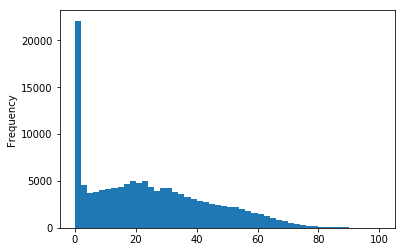

In [4]:
so['popularity'].plot(kind='hist', bins=50)

In [5]:
#find z-score for high popularity
pop = so['popularity']

z_of_90 = (90 - pop.mean()) / pop.std()
z_of_90

3.3374105858281022

In [6]:
low_pop = so[so['popularity'] <= 10]
len(low_pop)

40195

In [44]:
#percentage of songs with popularity at or below 10
(len(low_pop) / len(so)) * 100

30.762342820844463

The last few outputs demonstrate how rare songs are with high popularity ratings, and that a large portion of songs -- over 30% -- are virtually irrelevant. In fact, a score of 0 is by far the most frequent. 

This illustrates the problem that popularity may not have a formula. I need to find a way to come to terms with the fact that a large part of the equation comes down to marketing and cultural factors. It might be beneficial to drop all rows with a popularity rating of 0 because, even if they have the exact same characteristics as popular songs, they may simply not be popular due to factors outside the scope of this analysis.

#### Exploring and visualizing correlations

In [73]:
#which artists occur the most?
so[['track_name', 'artist_name']].groupby('artist_name').count().sort_values('track_name', ascending=False)

,track_name
artist_name,
Johann Sebastian Bach,3621
Wolfgang Amadeus Mozart,1755
Armin van Buuren,1124
Ludwig van Beethoven,928
Frédéric Chopin,614
Claude Debussy,451
Image Sounds,369
Waka Flocka Flame,273
Los Cadetes De Linares,266


Just some plot experiments below:

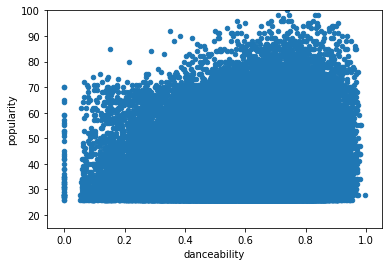

In [54]:
so[so['popularity'] > 25].plot(kind='scatter', x='danceability', y='popularity', ylim=[15,100])

plt.show()

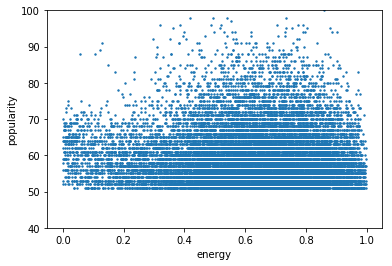

In [67]:
so[so['popularity'] > 50].plot(kind='scatter', x='energy', y='popularity', ylim=[40,100], s=2)

plt.show()

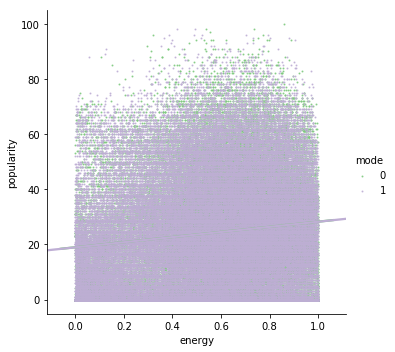

In [8]:
import seaborn as sns

sns.lmplot(x='energy', y='popularity', hue='mode', palette="Accent", scatter_kws={"s": 1}, data=so)
plt.show()

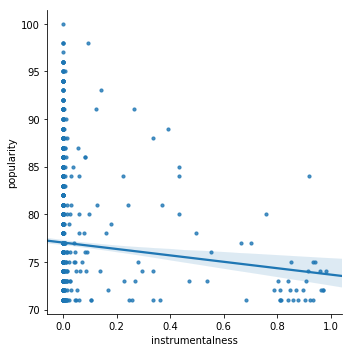

In [9]:
above_70 = so[so['popularity'] > 70]

#compare with instrumentalness
sns.lmplot(x='instrumentalness', y='popularity', data=above_70, scatter_kws={"s": 10})

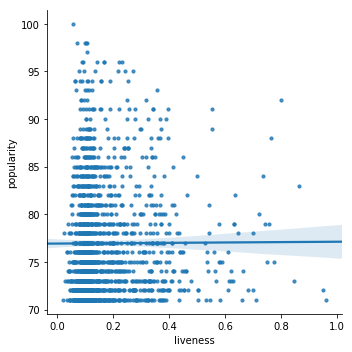

In [78]:
#compare with liveness
sns.lmplot(x='liveness', y='popularity', data=above_70, scatter_kws={"s": 10})

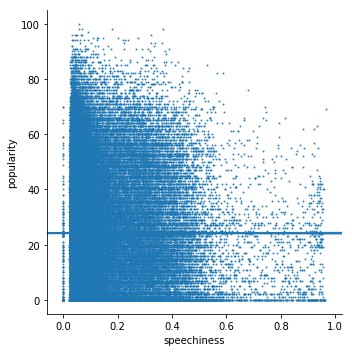

In [82]:
#compare with speechiness
sns.lmplot(x='speechiness', y='popularity', data=so, scatter_kws={"s": 1})

[(69, 102), (0, 1)]

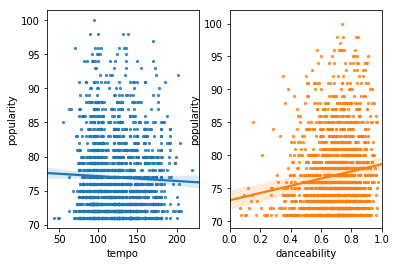

In [112]:
#Attempt to make subplots: tempo vs. danceability
fig, axs = plt.subplots(ncols=2, sharex=False)
sns.regplot(x='tempo', y='popularity', data=above_70, scatter_kws={"s": 5}, ax=axs[0])
x = sns.regplot(x='danceability', y='popularity', data=above_70, scatter_kws={"s": 5}, ax=axs[1])
x.set(xlim=(0,1), ylim=(69,102))

Attemp at feature selection:

In [13]:
from sklearn.feature_selection import SelectKBest, chi2
    
X_reg = so.iloc[:, [2,3,4,5,6,11,12]]
y_reg = so.loc[:, 'popularity']
X_new = SelectKBest(chi2, k=5).fit_transform(X_reg, y_reg)

pd.DataFrame(X_new)

,0,1,2,3,4
0,0.110000,193227.0,0.860,0.000002,93.989
1,0.163000,149520.0,0.539,0.000002,99.947
2,0.308000,194088.0,0.418,0.093000,131.926
3,0.520000,158040.0,0.494,0.000000,89.972
4,0.042700,181040.0,0.734,0.000000,137.958
5,0.042100,190440.0,0.554,0.000000,169.999
6,0.450000,171030.0,0.520,0.000002,102.998
7,0.371000,215733.0,0.385,0.000000,95.799
8,0.578000,178640.0,0.321,0.000000,70.142
9,0.191000,214290.0,0.792,0.000000,100.015


#### Missing values

In [115]:
so.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130663 entries, 1 to 130663
Data columns (total 16 columns):
artist_name         130663 non-null object
track_name          130663 non-null object
acousticness        130663 non-null float64
danceability        130663 non-null float64
duration_ms         130663 non-null int64
energy              130663 non-null float64
instrumentalness    130663 non-null float64
key                 130663 non-null int64
liveness            130663 non-null float64
loudness            130663 non-null float64
mode                130663 non-null int64
speechiness         130663 non-null float64
tempo               130663 non-null float64
time_signature      130663 non-null int64
valence             130663 non-null float64
popularity          130663 non-null int64
dtypes: float64(9), int64(5), object(2)
memory usage: 16.0+ MB


There appears to no null values, but for the sake of practice a few more tests are below:

In [122]:
so.all()

artist_name          True
track_name           True
acousticness        False
danceability        False
duration_ms          True
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
popularity          False
dtype: bool

In [117]:
so.any()

artist_name         True
track_name          True
acousticness        True
danceability        True
duration_ms         True
energy              True
instrumentalness    True
key                 True
liveness            True
loudness            True
mode                True
speechiness         True
tempo               True
time_signature      True
valence             True
popularity          True
dtype: bool

In [120]:
so[so.isnull()].count()

artist_name         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
popularity          0
dtype: int64

Now let's do some basic exploration of the dataset

In [94]:
#What is the shape?
spotify.shape

(130663, 17)

In [96]:
#Examine the first few rows
spotify.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [ ]:
#Examine the tail
spotify.tail()

In [ ]:
#gather some basic statistical info
spotify.describe()

In [ ]:
#Narrow the focus to a couple key columns
spotify[['danceability', 'popularity']].describe()

We can see from above that, based on the mean and upper quartile range, the large majority of songs listed in the dataset have a low popularity rating. Considering that popular songs are often characterized as "Top 40" or "Billboard 100", this shouldn't really be a surprise.


Now let's a look at the metadata

In [ ]:
spotify.info()

Now we can sort the columns into two lists

In [ ]:
#Define a sorting function
def col_types(df):
    """A function to sort columns into two lists based on whether they are
    numeric or non-numeric"""
    num=[]
    non_num=[]
    for col in df:
        if np.dtype(df[col]) in (['int32', 'int64', 'float32', 'float64', 'complex64', 'long']):
            num.append(df.loc[:, col].name)
        else:
            non_num.append(df.loc[:, col].name)
    print('These columns are numeric: ' + str(num)) 
    print( '\nThese columns are non-numeric: ' + str(non_num))

In [ ]:
#run the function on the dataset
col_types(spotify)

## <b>json exercise playpen</b>

In [2]:
projects = pd.read_json('data/world_bank_projects.json')

projects.columns

Index(['_id', 'approvalfy', 'board_approval_month', 'boardapprovaldate',
       'borrower', 'closingdate', 'country_namecode', 'countrycode',
       'countryname', 'countryshortname', 'docty', 'envassesmentcategorycode',
       'grantamt', 'ibrdcommamt', 'id', 'idacommamt', 'impagency',
       'lendinginstr', 'lendinginstrtype', 'lendprojectcost',
       'majorsector_percent', 'mjsector_namecode', 'mjtheme',
       'mjtheme_namecode', 'mjthemecode', 'prodline', 'prodlinetext',
       'productlinetype', 'project_abstract', 'project_name', 'projectdocs',
       'projectfinancialtype', 'projectstatusdisplay', 'regionname', 'sector',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector_namecode',
       'sectorcode', 'source', 'status', 'supplementprojectflg', 'theme1',
       'theme_namecode', 'themecode', 'totalamt', 'totalcommamt', 'url'],
      dtype='object')

In [3]:
projects = projects[['_id', 'approvalfy', 'country_namecode', 'countrycode', 'countryname', 'countryshortname', 'mjtheme', 'mjtheme_namecode', 'project_name']]

projects.shape

(500, 9)

In [4]:
grouped = projects[['countryshortname', 'project_name']].groupby('countryshortname').count()

#grouped.iloc[:10,:].sort_values('project_name', ascending=False)

ordered = grouped.sort_values('project_name', ascending=False)

top_10 = ordered.iloc[:10, :]

top_10

,project_name
countryshortname,
China,19
Indonesia,19
Vietnam,17
India,16
"Yemen, Republic of",13
Nepal,12
Bangladesh,12
Morocco,12
Mozambique,11


## <b>question 2</b> 

In [27]:
projects.loc[491, 'mjtheme_namecode']

[{'code': '10', 'name': 'Rural development'},
 {'code': '11', 'name': 'Environment and natural resources management'}]

In [6]:
themes = projects['mjtheme_namecode']

x = themes[1]

themes.head()

0    [{'code': '8', 'name': 'Human development'}, {...
1    [{'code': '1', 'name': 'Economic management'},...
2    [{'code': '5', 'name': 'Trade and integration'...
3    [{'code': '7', 'name': 'Social dev/gender/incl...
4    [{'code': '5', 'name': 'Trade and integration'...
Name: mjtheme_namecode, dtype: object

In [7]:
counter = {}

for row in themes:
    for d in row:
        if d['code'] in counter:
            counter[d['code']] += 1
        else:
            counter[d['code']] = 1
            
counter

{'8': 210,
 '11': 250,
 '1': 38,
 '6': 168,
 '5': 77,
 '2': 199,
 '7': 130,
 '4': 146,
 '10': 216,
 '9': 50,
 '3': 15}

In [8]:
import collections

count = collections.Counter()

for row in themes:
    for d in row:
        count[d['code']] += 1
        
count.most_common(10)

[('11', 250),
 ('10', 216),
 ('8', 210),
 ('2', 199),
 ('6', 168),
 ('4', 146),
 ('7', 130),
 ('5', 77),
 ('9', 50),
 ('1', 38)]

In [9]:
import json
from pandas.io.json import json_normalize

x = pd.DataFrame()
#for row in themes:
#    x.append(json_normalize(row[0]))
    
x

""


In [10]:
data = json.load(open('data/world_bank_projects.json'))

table = json_normalize(data, 'mjtheme_namecode', ['id'])

table.head(3)

,code,name,id
0,8,Human development,P129828
1,11,,P129828
2,1,Economic management,P144674


In [11]:
table[['name', 'code']].groupby('name').count().sort_values('code', ascending=False).head(10)

,code
name,
Environment and natural resources management,223
Rural development,202
Human development,197
Public sector governance,184
Social protection and risk management,158
Financial and private sector development,130
,122
Social dev/gender/inclusion,119
Trade and integration,72


In [28]:
table[['name', 'code']].groupby('code').count().sort_values('name', ascending=False).head(10)

,name
code,
11,250
10,216
8,210
2,199
6,168
4,146
7,130
5,77
9,50


### Question 3

In [12]:
table.head(10)

,code,name,id
0,8,Human development,P129828
1,11,,P129828
2,1,Economic management,P144674
3,6,Social protection and risk management,P144674
4,5,Trade and integration,P145310
5,2,Public sector governance,P145310
6,11,Environment and natural resources management,P145310
7,6,Social protection and risk management,P145310
8,7,Social dev/gender/inclusion,P144665
9,7,Social dev/gender/inclusion,P144665


In [13]:
codes = list(table['code'])
names = list(table['name'])

zipped = list(zip(codes, names))
zipped = sorted(list(set(zipped)))

for tuple in zipped:
    if tuple[1] == '':
        zipped.remove(tuple)
    
zipped

[('1', 'Economic management'),
 ('10', 'Rural development'),
 ('11', 'Environment and natural resources management'),
 ('2', 'Public sector governance'),
 ('3', 'Rule of law'),
 ('4', 'Financial and private sector development'),
 ('5', 'Trade and integration'),
 ('6', 'Social protection and risk management'),
 ('7', 'Social dev/gender/inclusion'),
 ('8', 'Human development'),
 ('9', 'Urban development')]

In [15]:
d = dict(zipped)
d

{'1': 'Economic management',
 '10': 'Rural development',
 '11': 'Environment and natural resources management',
 '2': 'Public sector governance',
 '3': 'Rule of law',
 '4': 'Financial and private sector development',
 '5': 'Trade and integration',
 '6': 'Social protection and risk management',
 '7': 'Social dev/gender/inclusion',
 '8': 'Human development',
 '9': 'Urban development'}

In [22]:
for entry in themes:
    for theme in entry:
        if theme['name'] == '':
            theme['name'] = d[theme['code']]
            
type(themes)

pandas.core.series.Series

In [25]:
projects['mjtheme_namecode'] = themes
projects.loc[0, 'mjtheme_namecode']

[{'code': '8', 'name': 'Human development'},
 {'code': '11', 'name': 'Environment and natural resources management'}]